In [1]:
import time
import requests
import pandas as pd
import numpy as np

from nixtla import NixtlaClient

from utilsforecast.losses import mae, smape, mse
from utilsforecast.evaluation import evaluate

from utilsforecast.plotting import plot_series
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

path_arh = 'preds/ARH(1) predictions/arh1_all_73days.csv' # results for ARH(1) n_components=5
path_pca_var = 'preds/PCA(1) predictions/pca_all_73days.csv' # results for PCA+VAR(1) n_components=5


In [2]:
def preprocess_preds(path, name):
    preds_df = pd.read_csv(path)

    ds = pd.date_range(
            start=nixtla_preds_df['ds'].iloc[0],  
            end=nixtla_preds_df['ds'].iloc[-1],  
            freq='h',
            tz='UTC'
    )

    preds_df['ds'] = ds
    
    return preds_df.melt(id_vars=['ds'], var_name='unique_id', value_name=name)


In [3]:
nixtla_preds_df = pd.read_csv('preds/nixtla_preds.csv')

nixtla_prepr_df = pd.concat([
    nixtla_preds_df[nixtla_preds_df['unique_id'] == 'AP-AP'],
    nixtla_preds_df[nixtla_preds_df['unique_id'] == 'DOM-DOM'],
    nixtla_preds_df[nixtla_preds_df['unique_id'] == 'JC-JC'],
    nixtla_preds_df[nixtla_preds_df['unique_id'] == 'PN-PN'],
    nixtla_preds_df[nixtla_preds_df['unique_id'] == 'RTO-RTO']],
    ignore_index=True
)

nixtla_preds_df['ds'] = pd.to_datetime(nixtla_preds_df['ds'], utc=True)  
nixtla_prepr_df.groupby('unique_id').head(2)

,unique_id,ds,y,NHITS,LSTM,TimeGPT
0,AP-AP,2024-07-20 04:00:00+00:00,5085.688,5065.2944,5232.6200,5102.9020
1,AP-AP,2024-07-20 05:00:00+00:00,4827.886,4723.8467,4861.5210,4841.2725
1752,DOM-DOM,2024-07-20 04:00:00+00:00,14351.834,14343.8030,14480.6260,14437.2180
1753,DOM-DOM,2024-07-20 05:00:00+00:00,13720.171,13655.8380,13714.7880,13831.4410
3504,JC-JC,2024-07-20 04:00:00+00:00,2610.169,2601.1025,2899.0660,2570.8665
3505,JC-JC,2024-07-20 05:00:00+00:00,2382.425,2389.8523,2654.9429,2347.0989
5256,PN-PN,2024-07-20 04:00:00+00:00,1713.094,1700.0620,1826.2871,1719.1959
5257,PN-PN,2024-07-20 05:00:00+00:00,1623.977,1611.4106,1735.7313,1650.9722
7008,RTO-RTO,2024-07-20 04:00:00+00:00,87675.617,87824.6000,90782.7000,88144.2700
7009,RTO-RTO,2024-07-20 05:00:00+00:00,82729.123,82127.3200,84951.0160,83695.8300


In [4]:
arh_df = preprocess_preds(path_arh, 'ARH(1)')
pca_var_df = preprocess_preds(path_pca_var, 'PCA+VAR(1)')

In [5]:
all_preds_df = pd.merge(nixtla_preds_df, arh_df, 'left', ['unique_id', 'ds'])
all_preds_df = pd.merge(all_preds_df, pca_var_df, 'left', ['unique_id', 'ds'])


In [6]:
evaluation = evaluate(
    all_preds_df,
    metrics=[mse, mae, smape],
    models=['NHITS', 'LSTM', 'TimeGPT', 'ARH(1)', 'PCA+VAR(1)'],
    target_col='y',
    id_col='unique_id'
)

pd.set_option('display.float_format', '{:.6f}'.format)
evaluation.sort_values(['unique_id', 'metric']).groupby('unique_id', group_keys=False).head()

,unique_id,metric,NHITS,LSTM,TimeGPT,ARH(1),PCA+VAR(1)
5,AP-AP,mae,265.232760,382.074836,244.596841,242.728235,240.992307
0,AP-AP,mse,157771.785757,254572.707129,133632.064055,116187.862375,116297.623914
10,AP-AP,smape,0.022741,0.033176,0.021081,0.021516,0.021290
6,DOM-DOM,mae,642.374757,861.898592,568.089292,622.758823,612.093106
1,DOM-DOM,mse,824268.556661,1375080.348713,660605.569200,684669.032430,667872.320175
11,DOM-DOM,smape,0.020752,0.027838,0.018319,0.020587,0.020179
7,JC-JC,mae,280.927306,299.278668,221.126685,219.679970,217.918149
2,JC-JC,mse,193375.763066,206024.945159,119568.306818,112751.317745,112294.480981
12,JC-JC,smape,0.044837,0.048681,0.036297,0.036071,0.035744
8,PN-PN,mae,86.816008,124.665769,73.284570,79.244716,78.728291


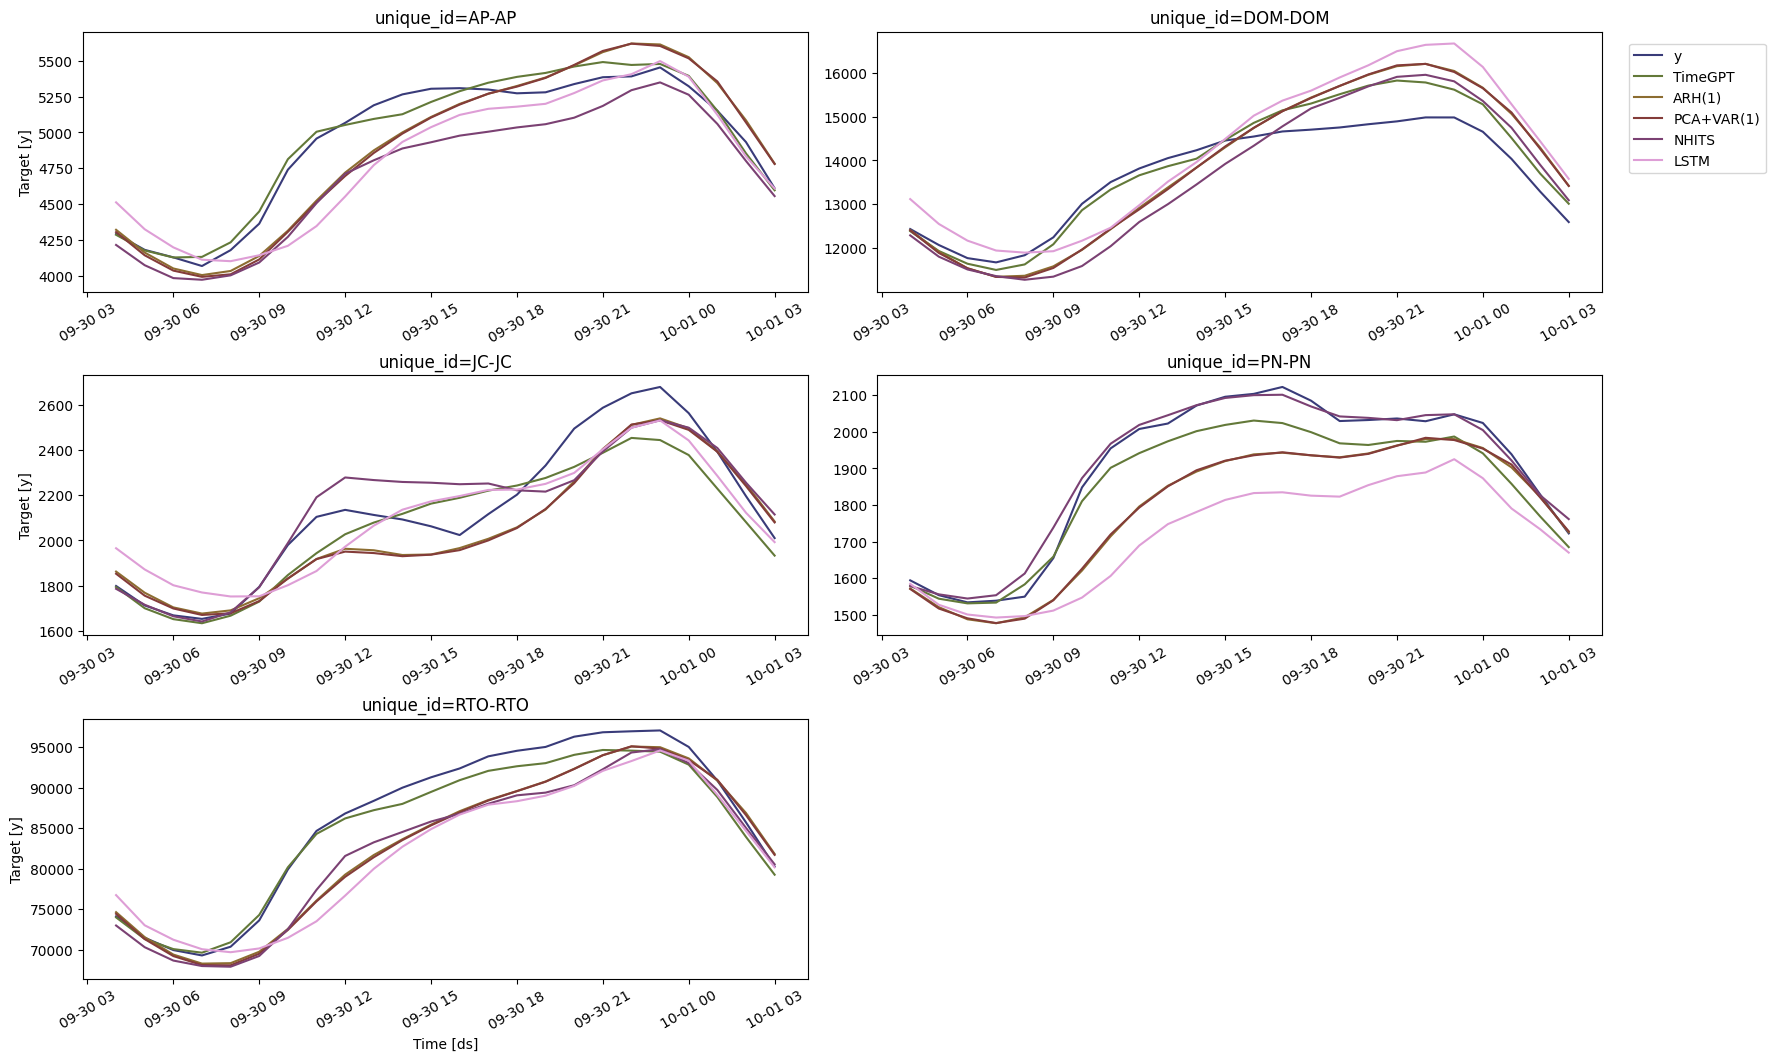

In [7]:
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-u0uuMKxJQLH7NljBpZRjckwKuENxptz6beRKSaVPvjPheR4P5H9J3Ju9rK47rGoN4qeUqlxgoqICfJ1O'
)


nixtla_client.plot(all_preds_df.groupby('unique_id').tail(24),
                   all_preds_df.drop(columns='y').groupby('unique_id').tail(24),
                   models=['TimeGPT', 'ARH(1)', 'PCA+VAR(1)', 'NHITS', 'LSTM'], time_col='ds',
                   target_col='y')
